# Mutli-agent network

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create a specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a [multi-agent network](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network) architecture.

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation, by Wu, et. al.](https://arxiv.org/abs/2308.08155)) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

<img src='./images/multi_agent_network.png'>

Before we get started, a quick note: this and other multi-agent notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

## Setup

In [ ]:
# !pip install -U langchain_community langchain_anthropic langchain_experimental matplotlib langgraph

In [1]:
import os
import keyring

# API KEY
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_mac')
ANTHROPIC_API_KEY = keyring.get_password('anthropic', 'key_for_mac')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_mac')

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['ANTHROPIC_API_KEY'] = ANTHROPIC_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Set up LangSmith observability
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = keyring.get_password('langsmith', 'learning_agent')
os.environ['LANGCHAIN_PROJECT'] = "pr-stupendous-hood-8"

## Define tools

We will also define some tools that our agents will use in the future

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to exeucte to generate your chart."],
):
    """Use this to execute python code. If you want to see the putput of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except Exception as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Succesfully executed:\n `\`\`python\n{code}\n`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

API Reference: [TavilySearchResults](https://python.langchain.com/api_reference/community/tools/langchain_community.tools.tavily_search.tool.TavilySearchResults.html) | [tool](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html) | [PythonREPL](https://python.langchain.com/api_reference/experimental/utilities/langchain_experimental.utilities.python.PythonREPL.html)

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define Agent Nodes

We now need to define the nodes.

First, we'll create a utility to create a system prompt for each agent.

In [4]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answerfing the quetion."
        " If you are unable to fully answer, that's OK, another assistant with different tools"
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistatn have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [12]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator collegue."
    ),
)

def research_node(
    state: MessagesState
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # Wrap in a human message, as not all providers allow
    # AI message at the last position of the input message list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # Share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )
    
# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARRY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    )
)

def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # Wrap in a human message, as not all providers allow
    # AI message at the lat position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # Share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto
    )

API Reference: [BaseMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.base.BaseMessage.html) | [HumanMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.human.HumanMessage.html) | [ChatAnthropic](https://python.langchain.com/api_reference/anthropic/chat_models/langchain_anthropic.chat_models.ChatAnthropic.html) | [create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent) | [END](https://langchain-ai.github.io/langgraph/reference/constants/#langgraph.constants.END) | [Command](https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.Command)

### Define the Graph

We can now put it all together and define the graph!

In [13]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

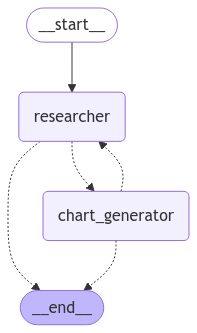

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it.", additional_kwargs={}, response_metadata={}, id='ef753dcd-f89b-4b8f-9465-080b966b9377'), AIMessage(content=[{'citations': None, 'text': "I'll help search for the UK's GDP data over the past 5 years. Then, I'll pass this information to my chart generator colleague for visualization.", 'type': 'text'}, {'id': 'toolu_015coLrKoxsvCwtKxsqmYpZ5', 'input': {'query': 'UK GDP annual values last 5 years 2019-2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01YU4FhDNJ9MLiHxAy83TrAn', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 550, 'output_tokens': 106}}, id='run-1a98dda0-fecb-48b0-b032-2a75f8154aa9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'quer

Python REPL can execute arbitrary code. Use with caution.


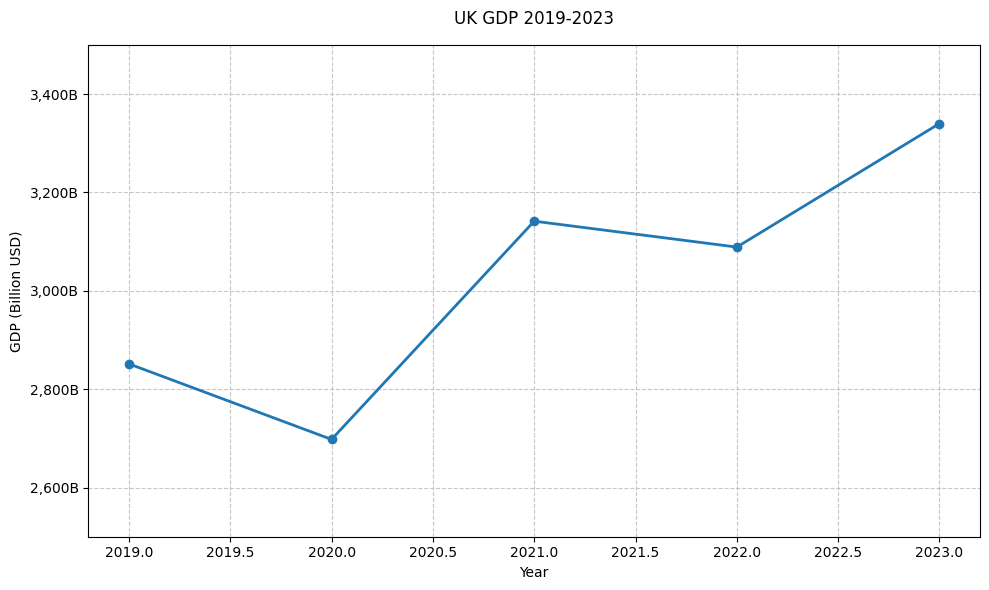

{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it.", additional_kwargs={}, response_metadata={}, id='ef753dcd-f89b-4b8f-9465-080b966b9377'), AIMessage(content=[{'citations': None, 'text': "I'll help search for the UK's GDP data over the past 5 years. Then, I'll pass this information to my chart generator colleague for visualization.", 'type': 'text'}, {'id': 'toolu_015coLrKoxsvCwtKxsqmYpZ5', 'input': {'query': 'UK GDP annual values last 5 years 2019-2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01YU4FhDNJ9MLiHxAy83TrAn', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 550, 'output_tokens': 106}}, id='run-1a98dda0-fecb-48b0-b032-2a75f8154aa9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {

In [16]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")